## Configurations for Colab

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install PyVirtualDisplay==3.0
    !pip install gymnasium==0.28.1
    !pip install pytorch-tcn
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()
from IPython.display import clear_output
from torch.optim.lr_scheduler import ExponentialLR

In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split
from pytorch_tcn import TCN
from tqdm import tqdm



# Network

In [3]:
import torch
import torch.nn as nn


class Network(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Network, self).__init__()
        
        self.lstm_1 = nn.LSTM(input_size=num_inputs, hidden_size=512, num_layers=1, batch_first=True)
        self.lstm_2 = nn.LSTM(input_size=512, hidden_size=512, num_layers=1, batch_first=True)        
        self.lstm_3 = nn.LSTM(input_size=512, hidden_size=512, num_layers=1, batch_first=True)
        
        self.Linear_layers = nn.Sequential(
            nn.Linear(512, num_outputs),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # print("======================================")
        # print(x.shape)
        
        # print("======================================")
        x, _ = self.lstm_1(x)  # Apply LSTM
        x, _ = self.lstm_2(x)
        x, _ = self.lstm_3(x)
        x = x[:, -1, :]  # Take the output of the last LSTM time step
        x = self.Linear_layers(x)  # Apply linear layers
        return x


## Data processing

In [4]:

# Set the device to GPU 2 (index 1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# intern
from intern.Merge_data import get_data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.001, 1)) 

df = get_data('./data/sensor_1')

#  drop Time(UTC+0) columns:
df.drop(columns=['Time(UTC+0)'], inplace=True)

# normalized

normalized_data = scaler.fit_transform(df)
df = pd.DataFrame(normalized_data, columns=df.columns)



num_features = 4
sequence_length = 128

# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

# Convert dataframe to numpy array
data = df.values

# Create sequences
sequences = create_sequences(data, sequence_length)

# Convert sequences to PyTorch tensors
X = torch.tensor(sequences, dtype=torch.float32).to(device)

# Create target tensor (e.g., predicting the closing price)
y = torch.tensor(df['PM2.5(μm/m^3)'][sequence_length:].values, dtype=torch.float32).unsqueeze(-1).to(device)

# Calculate the number of samples
num_samples = len(X)

# Calculate the number of samples for each set
num_train = int(num_samples * 0.8)
num_val = int(num_samples * 0.1)
num_test = num_samples - num_train - num_val

# Create dataset
dataset = TensorDataset(X, y)

# Split the dataset sequentially
train_dataset = TensorDataset(X[:num_train], y[:num_train])
val_dataset = TensorDataset(X[num_train:num_train+num_val], y[num_train:num_train+num_val])
test_dataset = TensorDataset(X[num_train+num_val:], y[num_train+num_val:])

15:03:34 Loaded backend module://matplotlib_inline.backend_inline version unknown.
15:03:34 Loaded backend module://matplotlib_inline.backend_inline version unknown.


<Figure size 1500x500 with 0 Axes>

In [6]:

# Create DataLoaders for each set
batch_size = 512

# Disable shuffling to maintain temporal order for LSTM
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def _plot(
        train_loss,
        val_loss,
        train_mapes,
        val_mapes,
        train_maes,
        val_maes,
        n: int = None,
        name = 'LSTM_training.png'
    ):
    # Plot the training progresses
    clear_output(True)
    plt.figure(figsize=(22, 5))  # Adjusted figure size
    
    if len(train_loss) > 0 and n is not None:
        plt.subplot(131)  # 1 row, 3 columns, 1st subplot
        plt.title('Loss')
        plt.plot(train_loss[-n:], label='Train')
        plt.plot(val_loss[-n:], label='Validation')
        plt.legend()
        
        plt.subplot(132)  # 1 row, 3 columns, 2nd subplot
        plt.title('MAPE')
        plt.plot(train_mapes[-n:], label='Train')
        plt.plot(val_mapes[-n:], label='Validation')
        plt.legend()
        
        plt.subplot(133)  # 1 row, 3 columns, 3rd subplot
        plt.title('MAE')
        plt.plot(train_maes[-n:], label='Train')
        plt.plot(val_maes[-n:], label='Validation')
        plt.legend()
        
    elif len(train_loss) > 0 and n is None:
        plt.subplot(131)  # 1 row, 3 columns, 1st subplot
        plt.title('Loss')
        plt.plot(train_loss, label='Train')
        plt.plot(val_loss, label='Validation')
        plt.legend()
        
        plt.subplot(132)  # 1 row, 3 columns, 2nd subplot
        plt.title('MAPE')
        plt.plot(train_mapes, label='Train')
        plt.plot(val_mapes, label='Validation')
        plt.legend()
        
        plt.subplot(133)  # 1 row, 3 columns, 3rd subplot
        plt.title('MAE')
        plt.plot(train_maes, label='Train')
        plt.plot(val_maes, label='Validation')
        plt.legend()
                
    plt.tight_layout()  # Adjust subplots to fit into the figure
    plt.savefig(name)
    plt.show()


In [8]:
# Instantiate the model, loss function, and optimizer
model = Network(num_inputs=4, num_outputs=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ExponentialLR(optimizer, gamma=0.95)
# Create a directory to save model checkpoints
checkpoint_dir = './model_checkpoints/LSTM'
os.makedirs(checkpoint_dir, exist_ok=True)



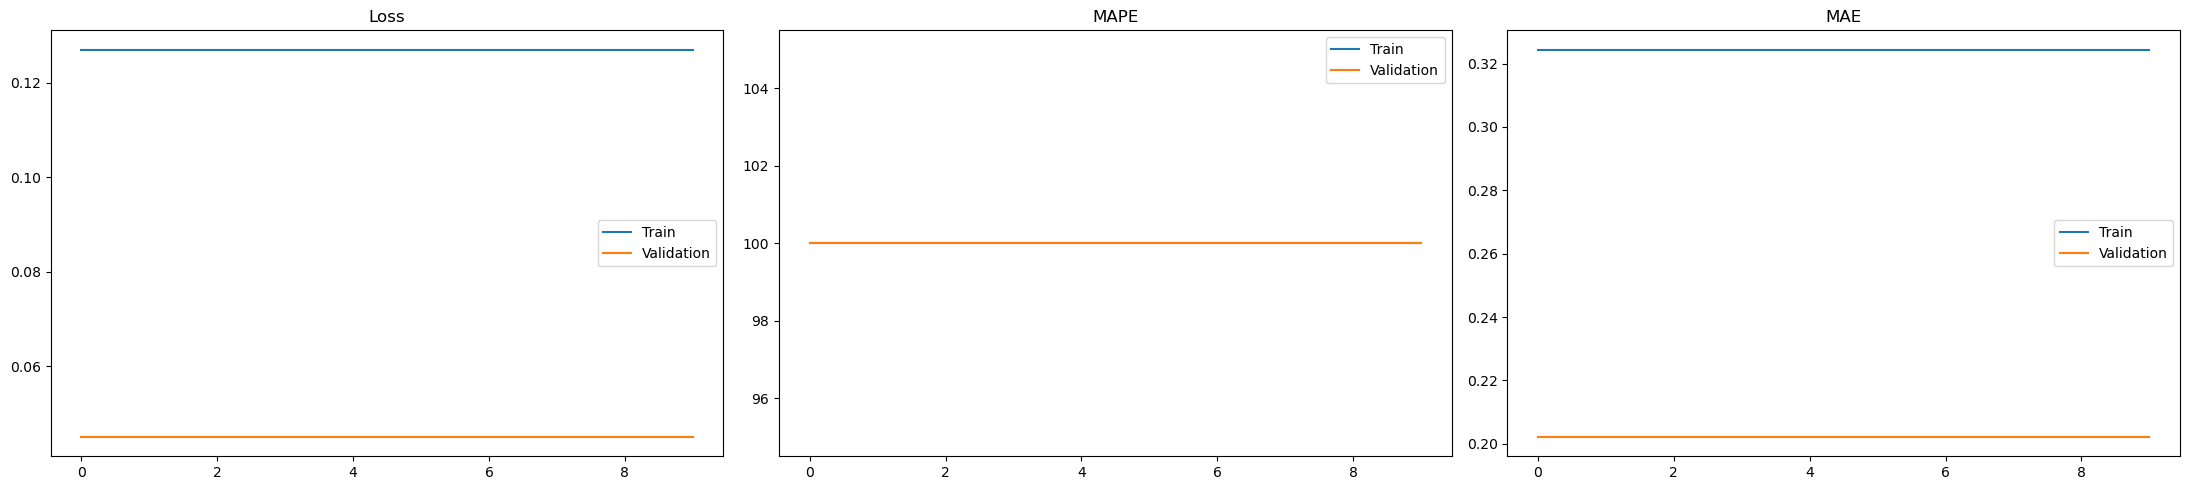

Training:   1%|          | 10/1000 [00:04<07:40,  2.15it/s, Train Loss=0.127, Val Loss=0.045, Train MAPE=100, Val MAPE=100, Train MAE=0.324, Val MAE=0.202]


In [9]:
# Training loop
num_epochs = 1000

train_losses = []
val_losses = []
train_mapes = []
val_mapes = []
train_maes = []
val_maes = []
not_improved_count = 0

train_progress = tqdm(range(num_epochs), desc="Training", position=0, leave=True)
for epoch in train_progress:
    model.train()
    train_loss = 0.0
    absolute_percentage_errors_train = []
    absolute_errors_train = []
    
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}", position=1, leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        
        # Compute MAPE and MAE for training data
        targets = targets.cpu().detach().numpy()
        outputs = outputs.cpu().detach().numpy()
        absolute_percentage_errors_train.extend(np.abs((targets - outputs) / targets) * 100)
        absolute_errors_train.extend(np.abs(targets - outputs))
    
    train_loss /= num_train
    train_losses.append(train_loss)
    train_mape = np.mean(absolute_percentage_errors_train)
    train_mapes.append(train_mape)
    train_mae = np.mean(absolute_errors_train)
    train_maes.append(train_mae)
    
    model.eval()
    val_loss = 0.0
    absolute_percentage_errors_val = []
    absolute_errors_val = []
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            
            # Compute MAPE and MAE for validation data
            targets = targets.cpu().detach().numpy()
            outputs = outputs.cpu().detach().numpy()
            absolute_percentage_errors_val.extend(np.abs((targets - outputs) / targets) * 100)
            absolute_errors_val.extend(np.abs(targets - outputs))
    
    val_loss /= num_val
    val_losses.append(val_loss)
    val_mape = np.mean(absolute_percentage_errors_val)
    val_mapes.append(val_mape)
    val_mae = np.mean(absolute_errors_val)
    val_maes.append(val_mae)
    # Save the model checkpoint
    not_improved_count += 1
    if len(val_losses) > 1 and val_loss < min(val_losses[:-1]):
        not_improved_count = 0
        checkpoint_path = os.path.join(checkpoint_dir, f'best.pth')
        torch.save(model.state_dict(), checkpoint_path)
    if not_improved_count > 10:
        break

    
    train_progress.set_postfix({"Train Loss": train_loss, "Val Loss": val_loss, "Train MAPE": train_mape, "Val MAPE": val_mape, "Train MAE": train_mae, "Val MAE": val_mae})
    # Plot losses, MAPEs, and MAEs after each epoch
    _plot(train_losses, val_losses, train_mapes, val_mapes, train_maes, val_maes, name='LSTM_training_1.png')

## Test 1

In [10]:
# Instantiate the model, loss function, and optimizer
model = Network(num_inputs=4, num_outputs=1).to(device)
model.load_state_dict(torch.load('./model_checkpoints/LSTM/best.pth'))

<All keys matched successfully>

In [11]:

# Evaluate the model on the test set
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)

test_loss /= num_test

print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0010


In [12]:
# Load the dataset
df_descale = get_data('./intern/')

# Calculate min and max for scaling
min_P = df_descale['PM2.5(μm/m^3)'].min()
max_P = df_descale['PM2.5(μm/m^3)'].max()

# Print min and max for verification
print("Minimum PM2.5(μm/m^3):", min_P)
print("Maximum PM2.5(μm/m^3):", max_P)


Minimum PM2.5(μm/m^3): 3.3
Maximum PM2.5(μm/m^3): 129.46


<Figure size 1500x500 with 0 Axes>

In [13]:
# intern
from intern.Merge_data import get_data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df = get_data('./data/sensor_3')

#  drop Time(UTC+0) columns:
df.drop(columns=['Time(UTC+0)'], inplace=True)

# normalized

normalized_data = scaler.fit_transform(df)
df = pd.DataFrame(normalized_data, columns=df.columns)



num_features = 4
sequence_length = 128

# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

# Convert dataframe to numpy array
data = df.values

# Create sequences
sequences = create_sequences(data, sequence_length)

# Convert sequences to PyTorch tensors
X = torch.tensor(sequences, dtype=torch.float32).to(device)

# Create target tensor (e.g., predicting the closing price)
y = torch.tensor(df['PM2.5(μm/m^3)'][sequence_length:].values, dtype=torch.float32).unsqueeze(-1).to(device)

# Calculate the number of samples
num_samples = len(X)

# Calculate the number of samples for each set
num_train = int(num_samples * 0.8)
num_val = int(num_samples * 0.1)
num_test = num_samples - num_train - num_val

# Create dataset
dataset = TensorDataset(X, y)

<Figure size 1500x500 with 0 Axes>

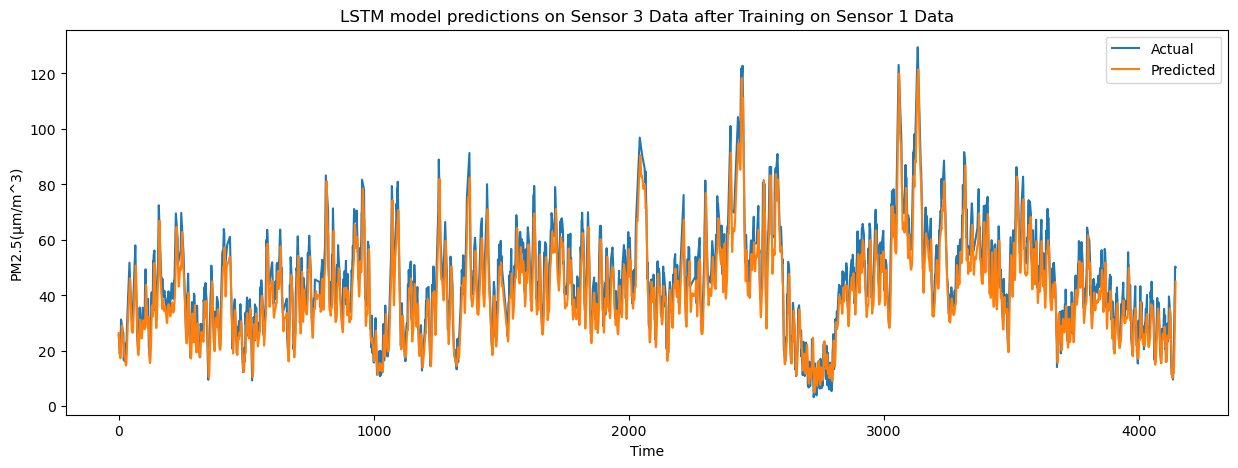

In [14]:
# Generate predictions on the entire dataset in order
all_loader = DataLoader(dataset, batch_size=1, shuffle=False)
all_predictions = []
model.eval()
with torch.no_grad():
    for inputs, _ in all_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        all_predictions.append(outputs.item())

# Convert predictions to numpy array
all_predictions = np.array(all_predictions)
# Descale all_predictions
descaled_all_predictions = all_predictions * (max_P - min_P) + min_P

# Descale df['PM2.5(μm/m^3)']
descaled_actual_values = df['PM2.5(μm/m^3)'].values[sequence_length:] * (max_P - min_P) + min_P

# Plot actual vs predicted
plt.figure(figsize=(15, 5))
plt.title('LSTM model predictions on Sensor 3 Data after Training on Sensor 1 Data') 
plt.plot(descaled_actual_values, label='Actual')
plt.plot(descaled_all_predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('PM2.5(μm/m^3)')
plt.legend()
plt.savefig('LSTM_1.png')
plt.show()

# Train 2

In [15]:
# intern
from intern.Merge_data import get_data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.001, 1)) 

df = get_data('./data/sensor_2')

#  drop Time(UTC+0) columns:
df.drop(columns=['Time(UTC+0)'], inplace=True)

# normalized

normalized_data = scaler.fit_transform(df)
df = pd.DataFrame(normalized_data, columns=df.columns)



num_features = 4
sequence_length = 128

# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

# Convert dataframe to numpy array
data = df.values

# Create sequences
sequences = create_sequences(data, sequence_length)

# Convert sequences to PyTorch tensors
X = torch.tensor(sequences, dtype=torch.float32).to(device)

# Create target tensor (e.g., predicting the closing price)
y = torch.tensor(df['PM2.5(μm/m^3)'][sequence_length:].values, dtype=torch.float32).unsqueeze(-1).to(device)

# Calculate the number of samples
num_samples = len(X)

# Calculate the number of samples for each set
num_train = int(num_samples * 0.8)
num_val = int(num_samples * 0.1)
num_test = num_samples - num_train - num_val

# Create dataset
dataset = TensorDataset(X, y)

# Split the dataset sequentially
train_dataset = TensorDataset(X[:num_train], y[:num_train])
val_dataset = TensorDataset(X[num_train:num_train+num_val], y[num_train:num_train+num_val])
test_dataset = TensorDataset(X[num_train+num_val:], y[num_train+num_val:])

<Figure size 1500x500 with 0 Axes>

In [16]:

# Create DataLoaders for each set
batch_size = 512

# Disable shuffling to maintain temporal order for LSTM
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
# Instantiate the model, loss function, and optimizer
model = Network(num_inputs=4, num_outputs=1).to(device)
model.load_state_dict(torch.load('./model_checkpoints/LSTM/best.pth'))
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ExponentialLR(optimizer, gamma=0.95)

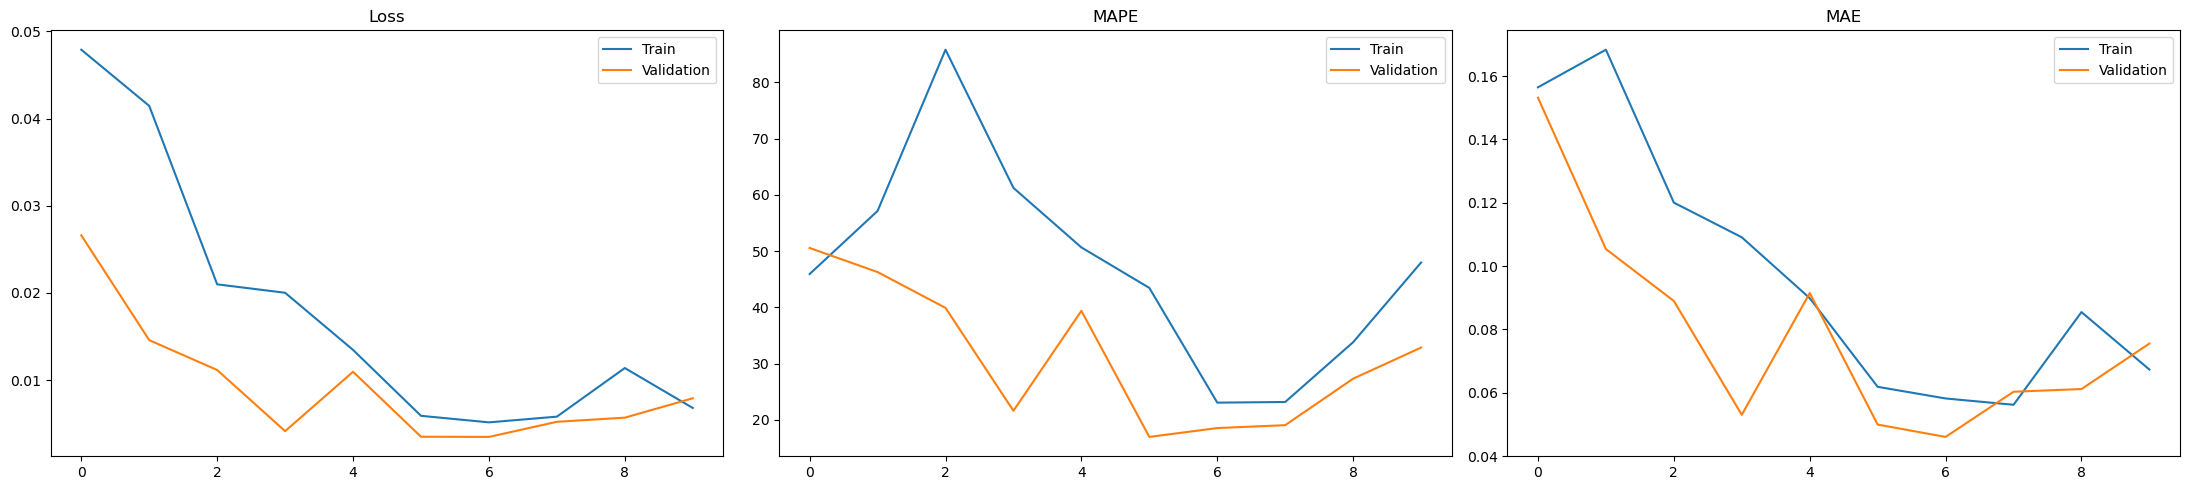

Training:   1%|          | 10/1000 [00:07<12:20,  1.34it/s, Train Loss=0.00681, Val Loss=0.00793, Train MAPE=48, Val MAPE=32.9, Train MAE=0.0673, Val MAE=0.0756]


In [18]:
# Training loop
num_epochs = 1000

train_losses = []
val_losses = []
train_mapes = []
val_mapes = []
train_maes = []
val_maes = []
not_improved_count = 0

train_progress = tqdm(range(num_epochs), desc="Training", position=0, leave=True)
for epoch in train_progress:
    model.train()
    train_loss = 0.0
    absolute_percentage_errors_train = []
    absolute_errors_train = []
    
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}", position=1, leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        
        # Compute MAPE and MAE for training data
        targets = targets.cpu().detach().numpy()
        outputs = outputs.cpu().detach().numpy()
        absolute_percentage_errors_train.extend(np.abs((targets - outputs) / targets) * 100)
        absolute_errors_train.extend(np.abs(targets - outputs))
    
    train_loss /= num_train
    train_losses.append(train_loss)
    train_mape = np.mean(absolute_percentage_errors_train)
    train_mapes.append(train_mape)
    train_mae = np.mean(absolute_errors_train)
    train_maes.append(train_mae)
    
    model.eval()
    val_loss = 0.0
    absolute_percentage_errors_val = []
    absolute_errors_val = []
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            
            # Compute MAPE and MAE for validation data
            targets = targets.cpu().detach().numpy()
            outputs = outputs.cpu().detach().numpy()
            absolute_percentage_errors_val.extend(np.abs((targets - outputs) / targets) * 100)
            absolute_errors_val.extend(np.abs(targets - outputs))
    
    val_loss /= num_val
    val_losses.append(val_loss)
    val_mape = np.mean(absolute_percentage_errors_val)
    val_mapes.append(val_mape)
    val_mae = np.mean(absolute_errors_val)
    val_maes.append(val_mae)
    # Save the model checkpoint
    not_improved_count += 1
    if len(val_losses) > 1 and val_loss < min(val_losses[:-1]):
        not_improved_count = 0
        checkpoint_path = os.path.join(checkpoint_dir, f'best.pth')
        torch.save(model.state_dict(), checkpoint_path)
    if not_improved_count > 10:
        break

    
    train_progress.set_postfix({"Train Loss": train_loss, "Val Loss": val_loss, "Train MAPE": train_mape, "Val MAPE": val_mape, "Train MAE": train_mae, "Val MAE": val_mae})
    # Plot losses, MAPEs, and MAEs after each epoch
    _plot(train_losses, val_losses, train_mapes, val_mapes, train_maes, val_maes, name='LSTM_training_2.png')

## Test

In [19]:
# Instantiate the model, loss function, and optimizer
model = Network(num_inputs=4, num_outputs=1).to(device)
model.load_state_dict(torch.load('./model_checkpoints/LSTM/best.pth'))

<All keys matched successfully>

In [20]:

# Evaluate the model on the test set
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)

test_loss /= num_test

print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0014


In [21]:
# Load the dataset
df_descale = get_data('./intern/')

# Calculate min and max for scaling
min_P = df_descale['PM2.5(μm/m^3)'].min()
max_P = df_descale['PM2.5(μm/m^3)'].max()

# Print min and max for verification
print("Minimum PM2.5(μm/m^3):", min_P)
print("Maximum PM2.5(μm/m^3):", max_P)


Minimum PM2.5(μm/m^3): 3.3
Maximum PM2.5(μm/m^3): 129.46


<Figure size 1500x500 with 0 Axes>

In [22]:
# intern
from intern.Merge_data import get_data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df = get_data('./data/sensor_3')

#  drop Time(UTC+0) columns:
df.drop(columns=['Time(UTC+0)'], inplace=True)

# normalized

normalized_data = scaler.fit_transform(df)
df = pd.DataFrame(normalized_data, columns=df.columns)



num_features = 4
sequence_length = 128

# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

# Convert dataframe to numpy array
data = df.values

# Create sequences
sequences = create_sequences(data, sequence_length)

# Convert sequences to PyTorch tensors
X = torch.tensor(sequences, dtype=torch.float32).to(device)

# Create target tensor (e.g., predicting the closing price)
y = torch.tensor(df['PM2.5(μm/m^3)'][sequence_length:].values, dtype=torch.float32).unsqueeze(-1).to(device)

# Calculate the number of samples
num_samples = len(X)

# Calculate the number of samples for each set
num_train = int(num_samples * 0.8)
num_val = int(num_samples * 0.1)
num_test = num_samples - num_train - num_val

# Create dataset
dataset = TensorDataset(X, y)

<Figure size 1500x500 with 0 Axes>

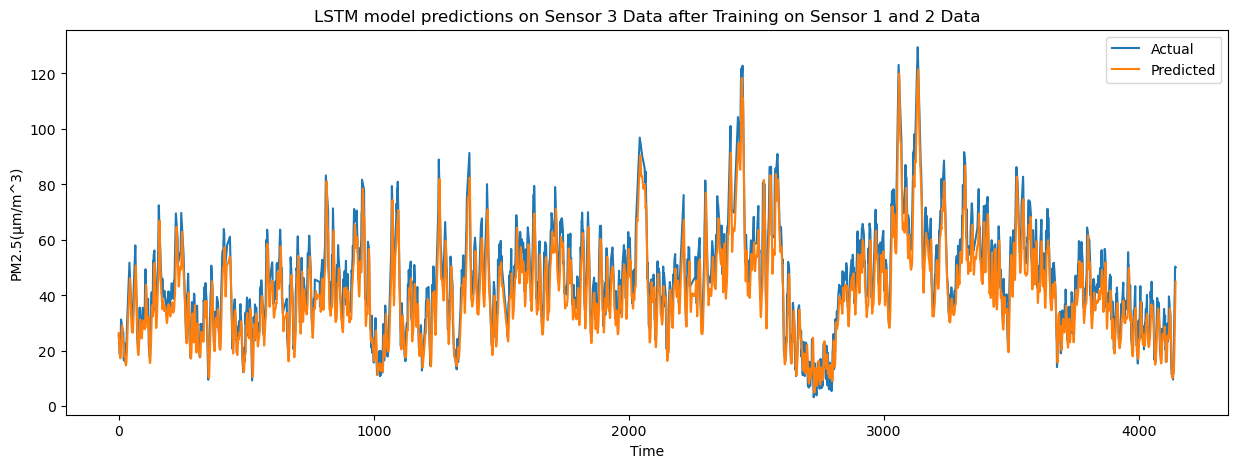

In [23]:
# Generate predictions on the entire dataset in order
all_loader = DataLoader(dataset, batch_size=1, shuffle=False)
all_predictions = []
model.eval()
with torch.no_grad():
    for inputs, _ in all_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        all_predictions.append(outputs.item())

# Convert predictions to numpy array
all_predictions = np.array(all_predictions)
# Descale all_predictions
descaled_all_predictions = all_predictions * (max_P - min_P) + min_P

# Descale df['PM2.5(μm/m^3)']
descaled_actual_values = df['PM2.5(μm/m^3)'].values[sequence_length:] * (max_P - min_P) + min_P

# Plot actual vs predicted
plt.figure(figsize=(15, 5))
plt.title('LSTM model predictions on Sensor 3 Data after Training on Sensor 1 and 2 Data') 
plt.plot(descaled_actual_values, label='Actual')
plt.plot(descaled_all_predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('PM2.5(μm/m^3)')
plt.legend()
plt.savefig('LSTM_2.png')
plt.show()